In [1]:
# bibliotecas matetmáticas
import math
import pandas as pd
import numpy as np

# bibliotecas para uso de redes neurais. Neste caso, do tipo LSTM
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense
# from tensorflow.keras.layers import LSTM
# from tensorflow.keras.layers import Dropout
# from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# bibliotecas para o pré-processamento dos dados. Normalização, etc...
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from scipy.signal import savgol_filter
import datetime
from functools import reduce

# bibliotecas para representação dos dados em gráficos
import plotly.offline as py
import plotly.graph_objs as go
import matplotlib.pyplot as plt

# métodos para pré-processamento do DataFrame original
import pre_processing as pp
import lstm_models as rnn

In [2]:
%%time
df = pd.read_csv('us-101-vehicle-trajectory-data/vehicle-trajectory-data/0805am-0820am/trajectories-0805am-0820am.csv')

CPU times: user 1.21 s, sys: 82.9 ms, total: 1.3 s
Wall time: 1.3 s


In [3]:
df = pp.add_positions_in_meters(df)

Para que os dados possam ser utilizados deve ser gerado um novo _DataFrame_ contendo as informações do __veículo alvo e dos 9 veículos ao redor mais próximos__, assim como na imagem abaixo:

![target and surrounding vehicles](./article_images/target_and_surrounding_vehicles.png
)

In [4]:
target_df = pp.get_target_dataframe(df, 1914)

In [5]:
road_total_width = 3.7 * 5
lane_points = []

lane_width = 0
for i in range(0, 5):
    lane_width += 3.7
    lane_points.append(lane_width) 

Gráfico da __trajetória do veículo 1914__, onde:
- __Posição Lateral__: corresponde à coluna _Local_X_meters_ que é a distância do veículo em relação á borda mais a esquerda da pista;
- __Posição Longitudinal__: corresponde à coluna _Local_Y_meters_ que é a distância percorrida pelo veículo na pista.

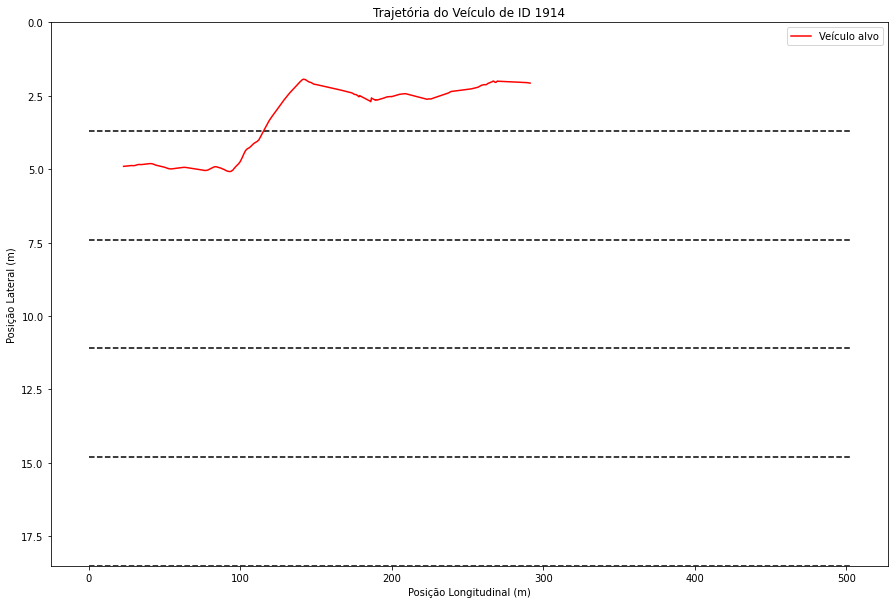

In [6]:
plt.figure(figsize=(15, 10))
line_red, = plt.plot(target_df['Local_Y_meters'], target_df['Local_X_meters'], color='red', label='Veículo alvo')
plt.title('Trajetória do Veículo de ID {}'.format(target_df['Vehicle_ID'][0]))
plt.ylabel('Posição Lateral (m)')
plt.xlabel('Posição Longitudinal (m)')
#plt.xticks(target_df['Local_Y_meters'])
plt.ylim(lane_points[-1], 0)
plt.hlines(lane_points, target_df.index.start, target_df.index.stop+50, colors='k', linestyles='dashed', label='Teste')
plt.legend(handles=[line_red,])

In [7]:
target_ids_list = df.Vehicle_ID.unique()
print('Quantidade de veículos:', len(target_ids_list))

Quantidade de veículos: 1533


# Previsão Utilizando Modelo Referenciado

In [8]:
%%time

import warnings
warnings.filterwarnings('ignore')

target_df_list = []
for target_id in target_ids_list[:20]:
    final_df = pp.get_complete_df(df, target_id)
    target_df_list.append(final_df)

CPU times: user 1min 48s, sys: 37.5 ms, total: 1min 48s
Wall time: 1min 48s


In [9]:
final_df = pd.concat(target_df_list)
final_df = final_df.reset_index(drop=True)
final_df = final_df.fillna(0)
final_df

,Frame_ID,Local_X_meters_targ,Local_Y_meters_targ,Local_X_Vel_targ,Local_Y_Vel_targ,v_Class_targ,Local_X_Vel_b,Relative_Y_Vel_b,Relative_Targ_X_b,Relative_Targ_Y_b,...,Relative_Targ_X_br,Relative_Targ_Y_br,Time_To_Collision_br,v_Class_br,Local_X_Vel_fr,Relative_Y_Vel_fr,Relative_Targ_X_fr,Relative_Targ_Y_fr,Time_To_Collision_fr,v_Class_fr
0,271,15.591624,35.015240,-0.033528,6.096074,1,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,272,15.588576,35.624848,-0.030480,6.096074,1,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,273,15.619361,36.215252,0.307852,5.904048,1,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,274,15.616313,36.824555,-0.030480,6.093026,1,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,275,15.615094,37.432943,-0.012192,6.083882,1,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13104,916,14.163619,653.717996,0.000000,16.483784,0,0.679712,-0.097537,-1.335650,-39.164228,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13105,917,14.163314,655.347171,-0.003048,16.291758,0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13106,918,14.155999,656.966594,-0.073153,16.194221,0,-0.198122,0.021336,2.282370,-17.240917,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13107,919,14.155084,658.490612,-0.009144,15.240185,0,-0.039624,-0.755913,2.279322,-17.165326,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Separação de dados de treino e teste para previsão do modelo referenciado:

In [10]:
train_df_len =  int(len(final_df) * 0.8)
print('Quantidade de dados de treino:', train_df_len)

Quantidade de dados de treino: 10487


In [11]:
train_data = final_df.iloc[:train_df_len, 1:60].values

In [14]:
test_data = final_df.iloc[train_df_len:, 1:60].values
print('Quantidade de dados de teste:', len(test_data))

Quantidade de dados de teste: 2622


In [12]:
normalizer = MinMaxScaler(feature_range=(0, 1))
normalized_train = normalizer.fit_transform(train_data)
normalized_train[0]

array([0.86894541, 0.03454765, 0.45670628, 0.27597627, 1.        ,
       0.51743638, 0.49496783, 0.56942199, 1.        , 0.50001913,
       0.        , 0.46604414, 0.62686873, 0.43057801, 0.        ,
       0.50001913, 0.        , 0.51549296, 0.49781138, 0.37626947,
       0.        , 0.29156334, 0.        , 0.44017725, 0.48227712,
       1.        , 0.50500539, 0.941171  , 0.        , 0.53191489,
       0.45869371, 1.        , 1.        , 1.        , 0.        ,
       0.2704    , 0.42146597, 1.        , 0.        , 0.23830357,
       0.        , 0.57972545, 0.50654922, 0.        , 0.49483901,
       0.92493913, 0.        , 0.33142037, 0.51804424, 0.        ,
       1.        , 0.4561991 , 0.        , 0.6039604 , 0.56937799,
       0.        , 0.        , 0.5055708 , 0.        ])

In [15]:
normalizer = MinMaxScaler(feature_range=(0, 1))
normalized_test = normalizer.fit_transform(test_data)
normalized_test[0]

array([0.96914387, 0.93598934, 0.42380423, 0.74266487, 0.        ,
       0.39402174, 0.47658501, 0.38841251, 0.23855345, 0.43170874,
       0.        , 0.48515982, 0.40107806, 0.22946966, 0.        ,
       0.44819173, 0.        , 0.28196347, 0.45226811, 0.47434275,
       0.        , 0.59701686, 0.        , 0.59228188, 0.49016046,
       1.        , 0.49976848, 0.66523737, 0.        , 0.53665689,
       0.42209141, 1.        , 1.        , 0.13519515, 0.        ,
       0.3125    , 0.61831863, 1.        , 0.        , 1.        ,
       0.        , 0.28963415, 0.52511898, 0.        , 0.50240273,
       0.72531985, 0.        , 0.54593176, 0.4750934 , 0.        ,
       1.        , 0.12135145, 0.        , 0.38241309, 0.44129325,
       0.        , 0.        , 0.75292644, 0.        ])

In [67]:
train_x, train_y_1 = rnn.dataset_with_look_back_for_multiple_predictors(normalized_train, 100, 0, 59, 0)
train_x, train_y_2 = rnn.dataset_with_look_back_for_multiple_predictors(normalized_train, 100, 0, 59, 3)
test_x, test_y_1 = rnn.dataset_with_look_back_for_multiple_predictors(normalized_test, 100, 0, 59, 0)
test_x, test_y_2 = rnn.dataset_with_look_back_for_multiple_predictors(normalized_test, 100, 0, 59, 3)

In [17]:
train_x.shape

(10387, 100, 59)

In [18]:
test_x.shape

(2522, 100, 59)

In [19]:
train_y = np.column_stack((train_y_1, train_y_2))
train_y

array([[0.9121385 , 0.35656134],
       [0.9134183 , 0.35656134],
       [0.91471587, 0.35669932],
       ...,
       [0.92913134, 0.75438112],
       [0.92998454, 0.75396716],
       [0.93016229, 0.76417828]])

In [68]:
test_y = np.column_stack((test_y_1, test_y_2))
test_y

array([[0.00407316, 0.00955585],
       [0.00407316, 0.00969044],
       [0.00407316, 0.00955585],
       ...,
       [0.81259607, 0.71507402],
       [0.81253843, 0.67294751],
       [0.81244236, 0.67294751]])

Representação do modelo LSTM utilizado:

![modelo LSTM](./article_images/lstm_representation.png)

In [23]:
model = rnn.lstm(train_x, train_y, 2)

Epoch 1/5
325/325 [==============================] - 41s 125ms/step - loss: 0.0640 - mean_absolute_error: 0.1661
Epoch 2/5
325/325 [==============================] - 44s 136ms/step - loss: 0.0089 - mean_absolute_error: 0.0728
Epoch 3/5
325/325 [==============================] - 47s 145ms/step - loss: 0.0065 - mean_absolute_error: 0.0621
Epoch 4/5
325/325 [==============================] - 47s 143ms/step - loss: 0.0054 - mean_absolute_error: 0.0571
Epoch 5/5
325/325 [==============================] - 46s 142ms/step - loss: 0.0047 - mean_absolute_error: 0.0525
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 256)               323584    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense (Dense)      

In [52]:
normalizer_predict_1 = MinMaxScaler(feature_range=(0, 1))
normalizer_predict_1.fit_transform(test_data[:,0:1])
normalizer_predict_2 = MinMaxScaler(feature_range=(0, 1))
normalizer_predict_2.fit_transform(test_data[:,3:4])
# normalizer_predict.fit_transform(test_data[:,3:4])

array([[0.74266487],
       [0.72099596],
       [0.70349933],
       ...,
       [0.71507402],
       [0.67294751],
       [0.67294751]])

In [69]:
test_predict = model.predict(test_x)
test_predict

array([[-0.05083893, -0.06090939],
       [-0.05086948, -0.06107112],
       [-0.05086724, -0.06093894],
       ...,
       [ 0.8420013 ,  0.6905    ],
       [ 0.8324402 ,  0.6835648 ],
       [ 0.833226  ,  0.6637876 ]], dtype=float32)

In [70]:
test_predict_1 = normalizer_predict_1.inverse_transform(test_predict[:, 0:1])
test_predict_2 = normalizer_predict_2.inverse_transform(test_predict[:, 1:2])
test_predict = np.column_stack((test_predict_1, test_predict_2))
test_predict

array([[ 0.45810032, -1.3794099 ],
       [ 0.4576157 , -1.3830726 ],
       [ 0.45765114, -1.380079  ],
       ...,
       [14.622497  , 15.637695  ],
       [14.470815  , 15.480634  ],
       [14.483281  , 15.032742  ]], dtype=float32)

In [71]:
test_y_1 = normalizer_predict_1.inverse_transform(test_y[:, 0:1])
test_y_2 = normalizer_predict_2.inverse_transform(test_y[:, 1:2])
test_y = np.column_stack((test_y_1, test_y_2))
test_y

array([[ 1.32924896,  0.21641063],
       [ 1.32924896,  0.21945867],
       [ 1.32924896,  0.21641063],
       ...,
       [14.15599854, 16.19422092],
       [14.15508413, 15.24018532],
       [14.15356011, 15.24018532]])

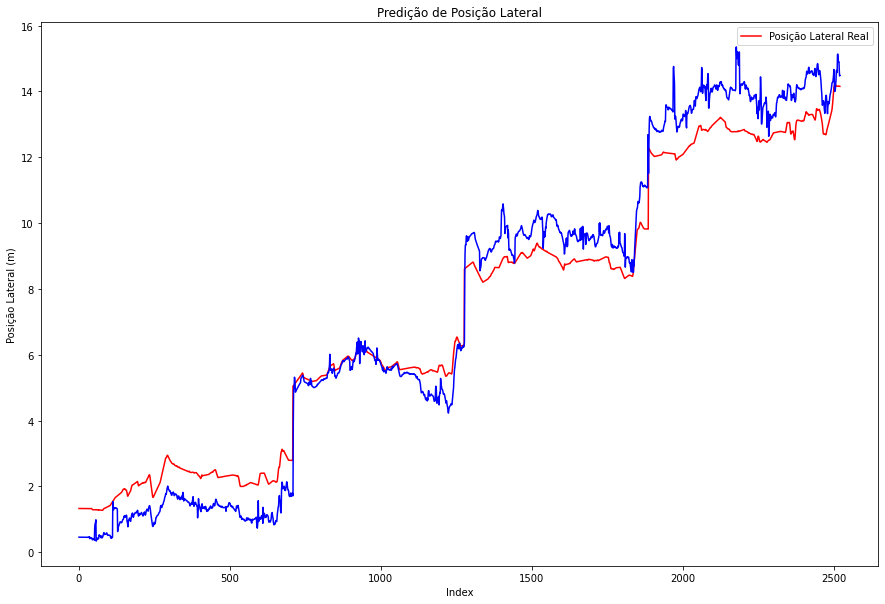

In [58]:
plt.figure(figsize=(15, 10))
line_red, = plt.plot(test_y[:, 0:1], color='red', label='Posição Lateral Real')
line_blue, = plt.plot(test_predict[:, 0:1], color='blue', label='Posição Lateral Prevista')
plt.title('Predição de Posição Lateral')
plt.xlabel('Index')
plt.ylabel('Posição Lateral (m)')
plt.legend(handles=[line_red,])

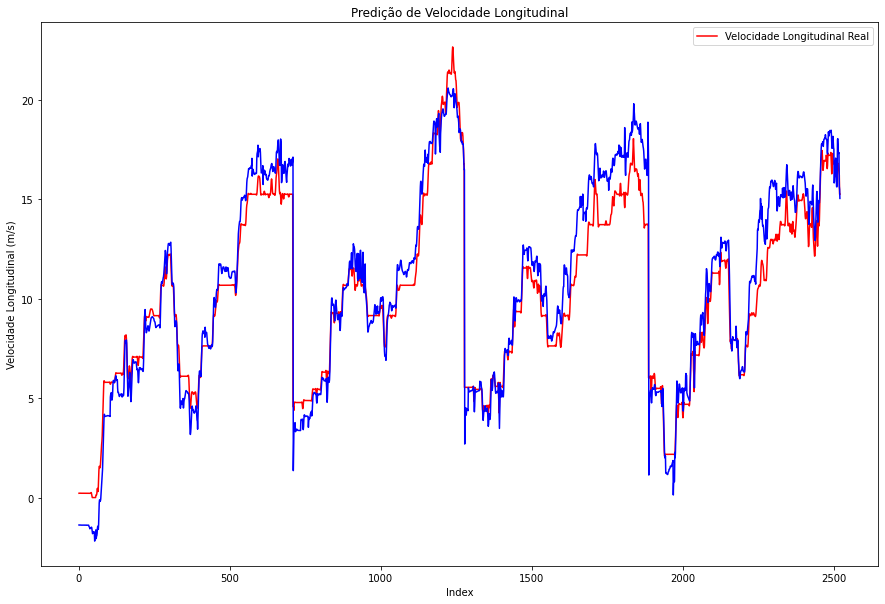

In [59]:
plt.figure(figsize=(15, 10))
line_red, = plt.plot(test_y[:, 1:2], color='red', label='Velocidade Longitudinal Real')
line_blue, = plt.plot(test_predict[:, 1:2], color='blue', label='Velocidade Longitudinal Prevista')
plt.title('Predição de Velocidade Longitudinal')
plt.xlabel('Index')
plt.ylabel('Velocidade Longitudinal (m/s)')
plt.legend(handles=[line_red,])

# Previsão Sem Tipo dos Veículos

Geração do _DataFrame_ sem os tipos dos veículos:

In [72]:
%%time
target_df_list = []
for target_id in target_ids_list[:20]:
    final_df = pp.get_complete_df(df, target_id, 1)
    target_df_list.append(final_df)

CPU times: user 1min 53s, sys: 0 ns, total: 1min 53s
Wall time: 1min 54s


In [73]:
final_df = pd.concat(target_df_list)
final_df = final_df.reset_index(drop=True)
final_df = final_df.fillna(0)
final_df

,Frame_ID,Local_X_meters_targ,Local_Y_meters_targ,Local_X_Vel_targ,Local_Y_Vel_targ,Local_X_Vel_b,Relative_Y_Vel_b,Relative_Targ_X_b,Relative_Targ_Y_b,Time_To_Collision_b,...,Local_X_Vel_br,Relative_Y_Vel_br,Relative_Targ_X_br,Relative_Targ_Y_br,Time_To_Collision_br,Local_X_Vel_fr,Relative_Y_Vel_fr,Relative_Targ_X_fr,Relative_Targ_Y_fr,Time_To_Collision_fr
0,271,15.591624,35.015240,-0.033528,6.096074,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,272,15.588576,35.624848,-0.030480,6.096074,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,273,15.619361,36.215252,0.307852,5.904048,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,274,15.616313,36.824555,-0.030480,6.093026,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,275,15.615094,37.432943,-0.012192,6.083882,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13104,916,14.163619,653.717996,0.000000,16.483784,0.679712,-0.097537,-1.335650,-39.164228,401.531250,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13105,917,14.163314,655.347171,-0.003048,16.291758,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13106,918,14.155999,656.966594,-0.073153,16.194221,-0.198122,0.021336,2.282370,-17.240917,-808.057143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13107,919,14.155084,658.490612,-0.009144,15.240185,-0.039624,-0.755913,2.279322,-17.165326,22.708065,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Separação de dados de treino e teste para previsão do modelo referenciado.

In [74]:
train_df_len =  int(len(final_df) * 0.8)

In [75]:
test_data = final_df.iloc[train_df_len:, 1:50].values

In [76]:
normalizer = MinMaxScaler(feature_range=(0, 1))
normalized_train = normalizer.fit_transform(train_data)
normalized_train[0]

array([0.86894541, 0.03454765, 0.45670628, 0.27597627, 1.        ,
       0.51743638, 0.49496783, 0.56942199, 1.        , 0.50001913,
       0.        , 0.46604414, 0.62686873, 0.43057801, 0.        ,
       0.50001913, 0.        , 0.51549296, 0.49781138, 0.37626947,
       0.        , 0.29156334, 0.        , 0.44017725, 0.48227712,
       1.        , 0.50500539, 0.941171  , 0.        , 0.53191489,
       0.45869371, 1.        , 1.        , 1.        , 0.        ,
       0.2704    , 0.42146597, 1.        , 0.        , 0.23830357,
       0.        , 0.57972545, 0.50654922, 0.        , 0.49483901,
       0.92493913, 0.        , 0.33142037, 0.51804424, 0.        ,
       1.        , 0.4561991 , 0.        , 0.6039604 , 0.56937799,
       0.        , 0.        , 0.5055708 , 0.        ])

In [77]:
normalizer = MinMaxScaler(feature_range=(0, 1))
normalized_test = normalizer.fit_transform(test_data)
normalized_test[0]

array([0.96914387, 0.93598934, 0.42380423, 0.74266487, 0.39402174,
       0.47658501, 0.38841251, 0.23855345, 0.43170874, 0.48515982,
       0.40107806, 0.22946966, 0.        , 0.44819173, 0.28196347,
       0.45226811, 0.47434275, 0.        , 0.59701686, 0.59228188,
       0.49016046, 1.        , 0.49976848, 0.66523737, 0.53665689,
       0.42209141, 1.        , 1.        , 0.13519515, 0.3125    ,
       0.61831863, 1.        , 0.        , 1.        , 0.28963415,
       0.52511898, 0.        , 0.50240273, 0.72531985, 0.54593176,
       0.4750934 , 0.        , 1.        , 0.12135145, 0.38241309,
       0.44129325, 0.        , 0.        , 0.75292644])

In [84]:
train_x, train_y_1 = rnn.dataset_with_look_back_for_multiple_predictors(normalized_train, 100, 0, 49, 0)
train_x, train_y_2 = rnn.dataset_with_look_back_for_multiple_predictors(normalized_train, 100, 0, 49, 3)
test_x, test_y_1 = rnn.dataset_with_look_back_for_multiple_predictors(normalized_test, 100, 0, 49, 0)
test_x, test_y_2 = rnn.dataset_with_look_back_for_multiple_predictors(normalized_test, 100, 0, 49, 3)

In [85]:
train_y = np.column_stack((train_y_1, train_y_2))
test_y = np.column_stack((test_y_1, test_y_2))

In [86]:
model = rnn.lstm(train_x, train_y, 2)

Epoch 1/5
325/325 [==============================] - 40s 122ms/step - loss: 0.0413 - mean_absolute_error: 0.1323
Epoch 2/5
325/325 [==============================] - 40s 123ms/step - loss: 0.0084 - mean_absolute_error: 0.0709
Epoch 3/5
325/325 [==============================] - 41s 126ms/step - loss: 0.0062 - mean_absolute_error: 0.0605
Epoch 4/5
325/325 [==============================] - 41s 125ms/step - loss: 0.0050 - mean_absolute_error: 0.0545
Epoch 5/5
325/325 [==============================] - 42s 128ms/step - loss: 0.0044 - mean_absolute_error: 0.0510
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 256)               313344    
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)  

In [87]:
normalizer_predict_1 = MinMaxScaler(feature_range=(0, 1))
normalizer_predict_1.fit_transform(test_data[:,0:1])
normalizer_predict_2 = MinMaxScaler(feature_range=(0, 1))
normalizer_predict_2.fit_transform(test_data[:,3:4])

array([[0.74266487],
       [0.72099596],
       [0.70349933],
       ...,
       [0.71507402],
       [0.67294751],
       [0.67294751]])

In [88]:
test_predict = model.predict(test_x)
test_predict

array([[0.19142324, 0.11207034],
       [0.19139545, 0.11194804],
       [0.19141051, 0.11206639],
       ...,
       [0.9216063 , 0.7797488 ],
       [0.9048782 , 0.8016718 ],
       [0.9130271 , 0.80503803]], dtype=float32)

In [89]:
test_predict_1 = normalizer_predict_1.inverse_transform(test_predict[:, 0:1])
test_predict_2 = normalizer_predict_2.inverse_transform(test_predict[:, 1:2])
test_predict = np.column_stack((test_predict_1, test_predict_2))
test_predict

array([[ 4.30145  ,  2.5380476],
       [ 4.301009 ,  2.5352776],
       [ 4.3012476,  2.537958 ],
       ...,
       [15.885384 , 17.658905 ],
       [15.620002 , 18.155394 ],
       [15.749279 , 18.231628 ]], dtype=float32)

In [90]:
test_y_1 = normalizer_predict_1.inverse_transform(test_y[:, 0:1])
test_y_2 = normalizer_predict_2.inverse_transform(test_y[:, 1:2])
test_y = np.column_stack((test_y_1, test_y_2))
test_y

array([[ 1.32924896,  0.21641063],
       [ 1.32924896,  0.21945867],
       [ 1.32924896,  0.21641063],
       ...,
       [14.15599854, 16.19422092],
       [14.15508413, 15.24018532],
       [14.15356011, 15.24018532]])

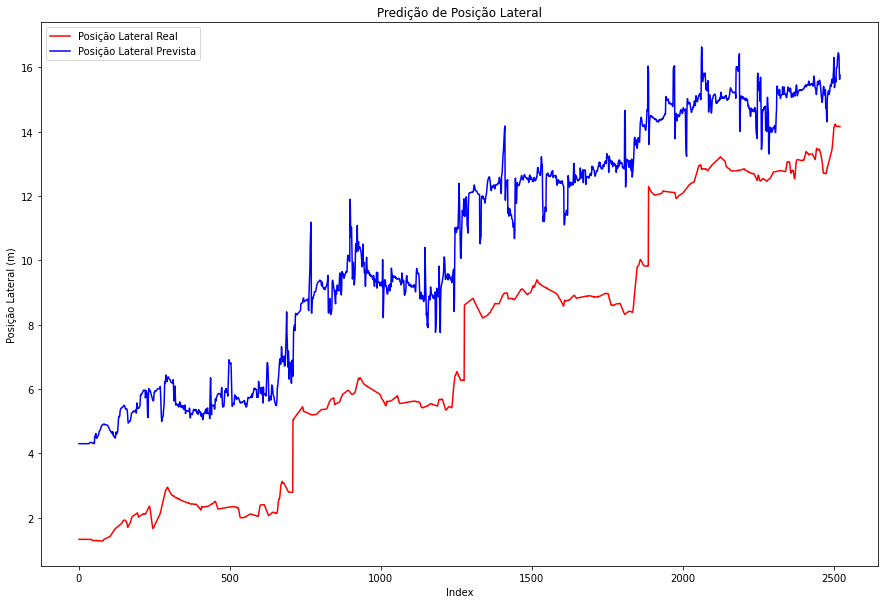

In [91]:
plt.figure(figsize=(15, 10))
line_red, = plt.plot(test_y[:, 0:1], color='red', label='Posição Lateral Real')
line_blue, = plt.plot(test_predict[:, 0:1], color='blue', label='Posição Lateral Prevista')
plt.title('Predição de Posição Lateral')
plt.xlabel('Index')
plt.ylabel('Posição Lateral (m)')
plt.legend(handles=[line_red, line_blue])

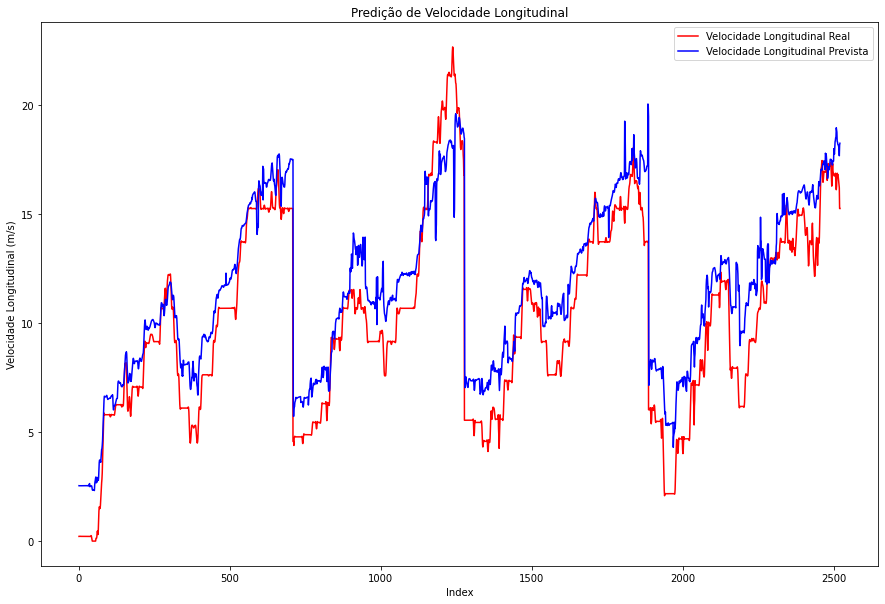

In [92]:
plt.figure(figsize=(15, 10))
line_red, = plt.plot(test_y[:, 1:2], color='red', label='Velocidade Longitudinal Real')
line_blue, = plt.plot(test_predict[:, 1:2], color='blue', label='Velocidade Longitudinal Prevista')
plt.title('Predição de Velocidade Longitudinal')
plt.xlabel('Index')
plt.ylabel('Velocidade Longitudinal (m/s)')
plt.legend(handles=[line_red, line_blue])